In [1]:
pwd()

"/Users/kyan/Projects/qgplsim"

# QGPLSIM fitting

In [31]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

α = [-1.0, 1.0, 2.0] # single index for x, α[1] = c0
θ = [0.0, 2.0, -1.0]  # linear for x, <α, θ> = 0 for identification, θ[1] = c1 := 0
γ = [0.5, 1.0] # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] 

# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n_ = 250
n0 = 500
n1 = 750
n2 = 1000
n3 = 1500
n = n2

fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for t
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5
intercept = 0
# Estimation 

model1 = qgplsim.model(X, Z, y, τ, intercept)
alpha_type = 1

# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for estimated  ̂α

@time alpha1, gamma, theta, beta, squ = qgplsim.estimator(model1, alpha_type)

println("Estimation of index coefs: ")
println("̂α => ", alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

println("square of integral: ", squ)

# theta * alpha

  0.253878 seconds (1.16 M allocations: 59.809 MiB, 4.92% gc time, 99.18% compilation time)


  2.454872 seconds (12.11 M allocations: 3.447 GiB, 13.86% gc time, 50.40% compilation time)
Estimation of index coefs: 
̂α => [0.45653650957375513, 0.8897046787705528]
̂γ => [0.1597901712859645, 0.657323461222245]
Estimation of linear coefs: 
̂θ => [2.0078687494063994 -1.0303029897548948]
̂β => [0.6749036425517234, -0.3335059018217567]
square of integral: 2.267881240539179


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

width = 1.161163114103081
dy = 0.40688664569091904
dx = 2.6354962541013065


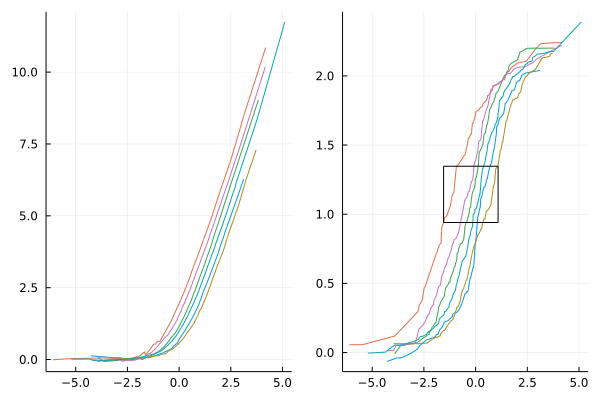

In [125]:
g = zeros(n)
dg = zeros(n)
yz = y - X * transpose(theta)


X = [ones(n, intercept) X]
v = X * alpha1 
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h * n/500
    vkmax = maximum(vk) - h * n/500

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println("width = ", mean(width))
# v0, v1 = v0 + h, v1 - h
# v0, v1

v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)
# _v, v_

C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = false ) # L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false ) # L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
println("dy = ", c1 - c0)
println("dx = ", v1 - v0)

plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

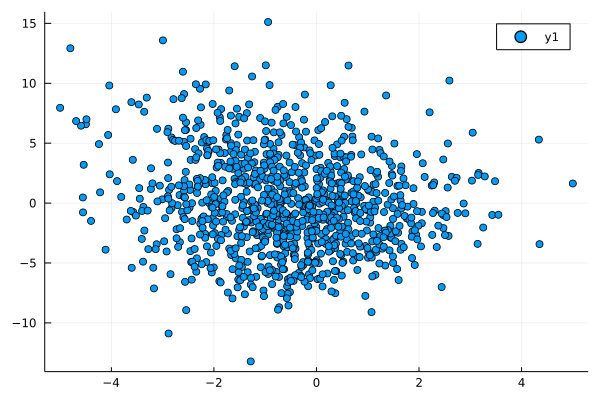

In [98]:
scatter(X[:,2], y)

# Monte Carlo Simulation

In [145]:
Threads.nthreads()

2

In [57]:
include("MonteCarloSIM.ji")

α = [-2.0, 1.0, -2.0] # single index for x
θ = [0.0, 2.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] 

τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = n0
fx = 1
dist = 1 # 1 for t
intercept = 1
rep = 200 # MC rept. times

200

## Different Quant

In [225]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.1, fx, dist, intercept, rep)

mb_ = mean(Beta, dims = 1)

mt_ = mean(Theta, dims = 1)

ma_ = mean(Alpha, dims = 1)

mg_ = mean(Gamma, dims = 1) 

265.834890 seconds (1.38 G allocations: 798.481 GiB, 33.33% gc time, 0.66% compilation time)


1×2 Matrix{Float64}:
 0.307931  0.594073

In [188]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.25, fx, dist, intercept, rep)

mb0 = mean(Beta, dims = 1)

mt0 = mean(Theta, dims = 1)

ma0 = mean(Alpha, dims = 1)

mg0 = mean(Gamma, dims = 1) 

 42.149247 seconds (366.49 M allocations: 143.178 GiB, 22.74% gc time)


1×2 Matrix{Float64}:
 0.360557  0.734407

In [190]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.75, fx, dist, intercept, rep)

mb2 = mean(Beta, dims = 1)

mt2 = mean(Theta, dims = 1)

ma2 = mean(Alpha, dims = 1)

mg2 = mean(Gamma, dims = 1) 

 41.438440 seconds (355.91 M allocations: 137.162 GiB, 28.01% gc time)


1×2 Matrix{Float64}:
 0.326819  0.722537

In [191]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.9, fx, dist, intercept, rep)

mb3 = mean(Beta, dims = 1)

mt3 = mean(Theta, dims = 1)

ma3 = mean(Alpha, dims = 1)

mg3 = mean(Gamma, dims = 1) 

 44.918757 seconds (403.71 M allocations: 162.037 GiB, 28.08% gc time)


1×2 Matrix{Float64}:
 0.316076  0.676516

## $\tau = 0.5$ 

In [58]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.5, fx, dist, intercept, rep)

mb1 = mean(Beta, dims = 1)

mt1 = mean(Theta, dims = 1)

ma1 = mean(Alpha, dims = 1)

mg1 = mean(Gamma, dims = 1) 

 52.545293 seconds (758.96 M allocations: 304.736 GiB, 29.19% gc time, 2.64% compilation time)


1×2 Matrix{Float64}:
 -0.146146  -0.29876

In [55]:
ma1

1×3 Matrix{Float64}:
 0.226084  0.10363  -0.196921

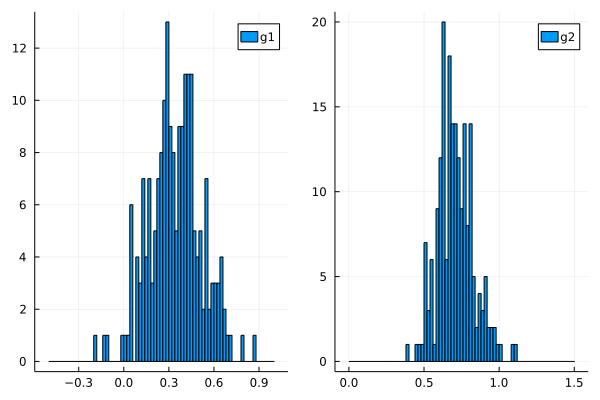

In [50]:
p1 = histogram(Gamma[:,1], bins = -0.5:0.02:1, label = "g1")
p2 = histogram(Gamma[:,2], bins = 0:0.02:1.5, label = "g2")
plot(p1, p2, layout = (1, 2))

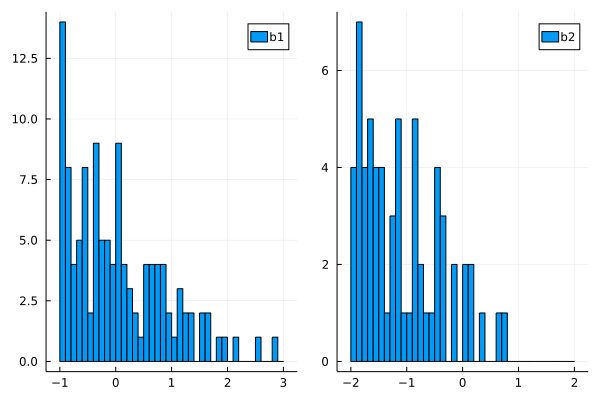

In [44]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

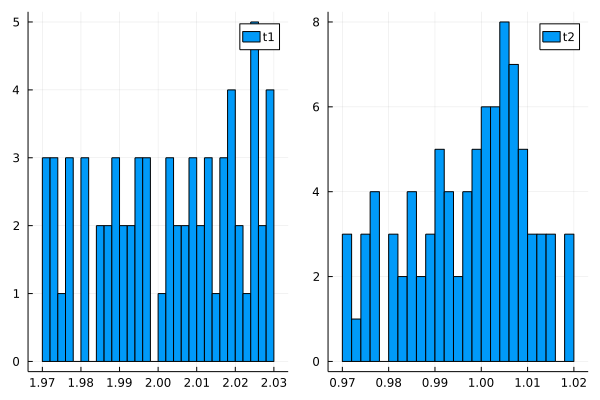

In [45]:
p1 = histogram(Theta[:,1], bins = 1.97:0.002:2.03, label = "t1")
p2 = histogram(Theta[:,2], bins = 0.97:0.002:1.02, label = "t2")
plot(p1, p2, layout = (1, 2))

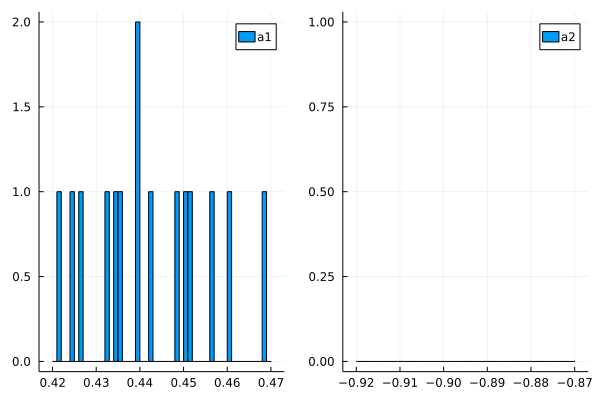

In [56]:
p1 = histogram(Alpha[:,1], bins = 0.42:0.001:0.47, label = "a1")
p2 = histogram(Alpha[:,2], bins = -0.92:0.001:-0.87, label = "a2")
plot(p1, p2, layout = (1, 2))

In [79]:
filename = "./simulations/records/250 f2 d1 1.0 0.5.mat"

"./simulations/records/250 f2 d1 1.0 0.5.mat"

In [80]:
using MAT, Statistics

In [81]:
d = matread(filename)
g = d["Gamma"]
a = d["Alpha"]
ma = mean(a, dims = 1)

1×2 Matrix{Float64}:
 0.428657  0.606587

In [82]:
mg = mean(g, dims = 1)

1×2 Matrix{Float64}:
 0.275254  0.126393

In [83]:
mg * 1.6

1×2 Matrix{Float64}:
 0.440406  0.202228